In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
Tmax = xr.open_dataset('Ghana_ERA5_dTx_1991_2023.nc')
Tmin = xr.open_dataset('Ghana_ERA5_dTn_1991_2023.nc')


In [4]:
Tmax

<xarray.Dataset>
Dimensions:          (valid_time: 12053, bnds: 2, longitude: 21, latitude: 31)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 1991-01-01T11:30:00 ... 2023...
  * longitude        (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 1.0 1.25 1.5
  * latitude         (latitude) float64 12.0 11.75 11.5 11.25 ... 5.0 4.75 4.5
Dimensions without coordinates: bnds
Data variables:
    valid_time_bnds  (valid_time, bnds) datetime64[ns] ...
    mx2t             (valid_time, latitude, longitude) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Thu Feb 27 15:56:46 2025: cdo -daymax -selyear,1...
    frequency:               day
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [8]:
Tmin

<xarray.Dataset>
Dimensions:          (valid_time: 12053, bnds: 2, longitude: 21, latitude: 31)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 1991-01-01T11:30:00 ... 2023...
  * longitude        (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 1.0 1.25 1.5
  * latitude         (latitude) float64 12.0 11.75 11.5 11.25 ... 5.0 4.75 4.5
Dimensions without coordinates: bnds
Data variables:
    valid_time_bnds  (valid_time, bnds) datetime64[ns] ...
    mn2t             (valid_time, latitude, longitude) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Thu Feb 27 15:54:49 2025: cdo -daymin -selyear,1...
    frequency:               day
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
Tmean = (Tmax["mx2t"] + Tmin["mn2t"]) / 2
Tmean.name = "Tmean"


In [11]:
# # 3-day mean ending on current day
# Tmean3 = Tmean.rolling(valid_time=3, center=False).mean()

# # 30-day mean ending on current day (acclimatisation)
# T30 = Tmean.rolling(valid_time=30, center=False).mean()


Tmean3 = Tmean.rolling(valid_time=3, center=False, min_periods=3).mean()
T30    = Tmean.rolling(valid_time=30, center=False, min_periods=30).mean()


In [12]:
# Add dayofyear coordinate to the daily DataArray
dayofyear = Tmean["valid_time"].dt.dayofyear
Tmean = Tmean.assign_coords(dayofyear=dayofyear)

# Compute the 95th percentile for each day-of-year across years
# result dims: ('dayofyear', 'latitude', 'longitude')
T95_doy = Tmean.groupby("dayofyear").quantile(0.95, dim="valid_time")


In [13]:
# Map percentile to each timestamp
T95_for_day = T95_doy.sel(dayofyear=Tmean["valid_time"].dt.dayofyear)

# EHI components
EHI_sig  = Tmean3 - T95_for_day
EHI_accl = Tmean3 - T30

# Multiplier rule: must be >= 1
multiplier = xr.where(EHI_accl > 1.0, EHI_accl, 1.0)

# EHF
EHF = EHI_sig * multiplier
EHF.name = "EHF"


In [16]:
import geopandas as gpd

# Load shapefile
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp")

ghana = ghana.to_crs("EPSG:4326")


In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import calendar
import regionmask

# --- Step 1: Mask Ghana region ---
ghana_mask = regionmask.Regions([ghana.geometry.iloc[0]])
EHF_masked = EHF.where(ghana_mask.mask(EHF) == 0)

# --- Step 2: Compute monthly climatology of EHF ---
EHF_monthly_mean = EHF_masked.groupby("valid_time.month").mean(dim="valid_time")

# --- Step 3: Plot function adapted for EHF ---
def plot_monthly_EHF(da_month, shapefile_gdf, cmap="Reds", title=""):
    fig, axes = plt.subplots(3, 4, figsize=(15, 9),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    months = range(1, 13)
    im = None

    for ax, m in zip(axes.flatten(), months):
        da = da_month.sel(month=m)

        im = da.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap,
            vmin=float(da_month.min()), vmax=float(da_month.max())
        )

        # Ghana shapefile overlay
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=1.0, transform=ccrs.PlateCarree())
        ax.coastlines(resolution="10m")
        ax.set_title(calendar.month_name[m], fontsize=10)

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label("Mean EHF")

    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.05, right=0.81, top=0.90, bottom=0.08,
                        wspace=0.05, hspace=0.25)
    plt.show()



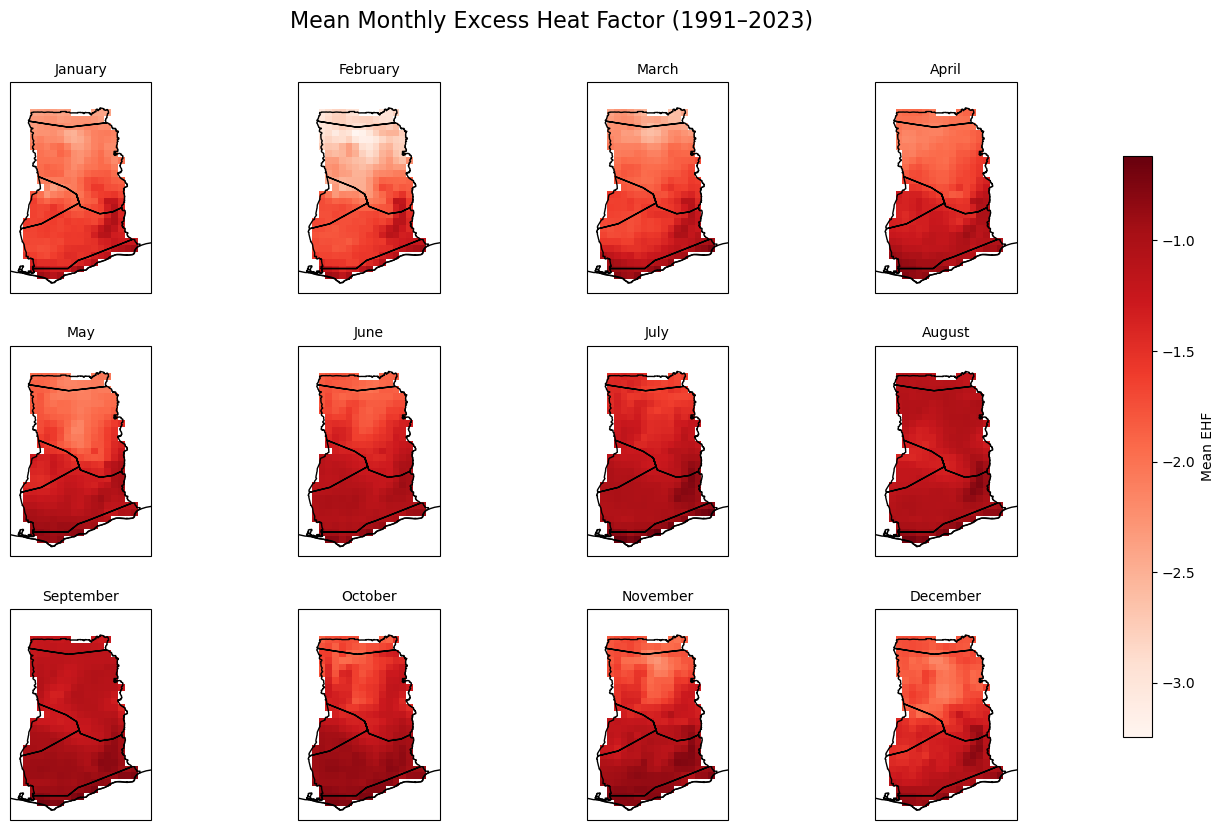

In [18]:
# --- Step 4: Call the plot function ---
plot_monthly_EHF(
    EHF_monthly_mean,
    ghana,
    cmap="Reds",
    title="Mean Monthly Excess Heat Factor (1991–2023)"
)


In [ ]:
# --- Full corrected EHF → monthly maps workflow ---
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import calendar
import regionmask
import geopandas as gpd

# ---------- User paths (edit if needed) ----------
tmax_path = "Ghana_ERA5_dTx_1991_2023.nc"
tmin_path = "Ghana_ERA5_dTn_1991_2023.nc"
ghana_shp = "gha_admbnda_adm0_gss_20210308.shp"

# Optional: path to baseline dataset that covers 1961-1990
baseline_tmean_path = None  # e.g., "Ghana_ERA5_Tmean_1961_1990.nc" or None to use 1991-2023 as climatology

# ---------- Load Tmax/Tmin ----------
ds_tmax = xr.open_dataset(tmax_path)
ds_tmin = xr.open_dataset(tmin_path)

# Detect time dim name (valid_time or time)
time_dim = "valid_time" if "valid_time" in ds_tmax.dims or "valid_time" in ds_tmax.coords else "time"
print("Using time dimension:", time_dim)

# Identify variable names (adjust if different)
tmax_var = "mx2t"
tmin_var = "mn2t"

tmax = ds_tmax[tmax_var]
tmin = ds_tmin[tmin_var]

# ---------- Units check: convert K -> C if needed ----------
def ensure_celsius(da):
    units = da.attrs.get("units", "").lower()
    sample = float(da.isel({time_dim: 0, "latitude": 0, "longitude": 0}).values)
    # Heuristic: if values look like 250..320 assume Kelvin
    if "k" in units or (sample > 200 and sample > 100): 
        da = da - 273.15
        da.attrs["units"] = "°C"
        print(f"Converted {da.name} from K to °C")
    else:
        print(f"{da.name} appears to be in °C (no conversion applied)")
    return da

tmax = ensure_celsius(tmax)
tmin = ensure_celsius(tmin)

# ---------- Basic cleaning of crazy values ----------
# mask physically implausible values (in °C)
tmax = tmax.where((tmax > -80) & (tmax < 60))
tmin = tmin.where((tmin > -80) & (tmin < 60))

# ---------- Align times (if any tiny mismatch) ----------
# floor times to day (should already be daily); ensures exact matching
tmax = tmax.assign_coords({time_dim: pd.to_datetime(tmax[time_dim].values).astype("datetime64[ns]")})
tmin = tmin.assign_coords({time_dim: pd.to_datetime(tmin[time_dim].values).astype("datetime64[ns]")})

# drop duplicate days if present (keep first)
_, idx = np.unique(tmax[time_dim].values, return_index=True)
tmax = tmax.isel({time_dim: idx})
_, idx = np.unique(tmin[time_dim].values, return_index=True)
tmin = tmin.isel({time_dim: idx})

# intersect time ranges (analysis period)
common = np.intersect1d(tmax[time_dim].values, tmin[time_dim].values)
tmax = tmax.sel({time_dim: common})
tmin = tmin.sel({time_dim: common})

# ---------- Compute daily mean temperature ----------
Tmean = (tmax + tmin) / 2.0
Tmean.name = "Tmean"

# Ensure dayofyear coord exists and is integer 1..366
doy = Tmean[time_dim].dt.dayofyear
Tmean = Tmean.assign_coords(dayofyear=doy)

# ---------- Rolling windows with min_periods ----------
Tmean3 = Tmean.rolling({time_dim: 3}, center=False, min_periods=3).mean()
T30    = Tmean.rolling({time_dim: 30}, center=False, min_periods=30).mean()

# ---------- Compute T95_doy (percentile baseline) ----------
if baseline_tmean_path:
    # If you have a baseline dataset (recommended), compute T95 from baseline period (e.g., 1961-1990).
    ds_base = xr.open_dataset(baseline_tmean_path)
    # assume baseline Tmean variable is same name or compute as (mx2t+mn2t)/2 similarly
    Tmean_base = (ds_base[tmax_var] + ds_base[tmin_var]) / 2.0
    Tmean_base = Tmean_base.assign_coords(dayofyear=Tmean_base[time_dim].dt.dayofyear)
    T95_doy = Tmean_base.groupby("dayofyear").quantile(0.95, dim=time_dim, skipna=True)
    print("Using baseline for T95_doy from:", baseline_tmean_path)
else:
    # Fallback: use the full available period (here 1991-2023) to compute T95_doy
    T95_doy = Tmean.groupby("dayofyear").quantile(0.95, dim=time_dim, skipna=True)
    print("WARNING: Using analysis period (1991-2023) to compute T95_doy (not canonical baseline).")

# Handle Feb 29: if dayofyear==366 is not present in T95_doy, map 366 -> 365
doys_available = T95_doy["dayofyear"].values
if 366 not in doys_available:
    print("Mapping dayofyear 366 -> 365 for Feb29 handling")
    # create a function for mapping 366 to 365 when selecting
    sel_doy = Tmean[time_dim].dt.dayofyear.where(Tmean[time_dim].dt.dayofyear != 366, 365)
else:
    sel_doy = Tmean[time_dim].dt.dayofyear

# Map T95 to each daily timestamp
T95_for_day = T95_doy.sel(dayofyear=sel_doy)

# ---------- EHI components and EHF ----------
EHI_sig  = Tmean3 - T95_for_day
EHI_accl = Tmean3 - T30

# Multiplier rule: max(1, EHI_accl)
multiplier = xr.where(EHI_accl > 1.0, EHI_accl, 1.0)

EHF = EHI_sig * multiplier
EHF.name = "EHF"

# Mask to positive EHF if you want to visualize only heat stress
EHF_pos = EHF.where(EHF > 0)

# ---------- Mask to Ghana ----------
ghana = gpd.read_file(ghana_shp)
ghana = ghana.to_crs("EPSG:4326")
ghana_mask = regionmask.Regions([ghana.geometry.iloc[0]])

# regionmask expects a DataArray with lon/lat coords; pass a representative array (EHF_pos)
mask = ghana_mask.mask(EHF_pos)  # gives indices; inside region will equal 0 (our single region)
EHF_pos_masked = EHF_pos.where(mask == 0)  # keep only inside Ghana

# ---------- Monthly aggregation (mean EHF over days where EHF>0) ----------
EHF_monthly_mean = EHF_pos_masked.groupby(f"{time_dim}.month").mean(dim=time_dim, skipna=True)
EHF_monthly_mean.name = "mean_EHF_pos"

# If you prefer total days with EHF>0 per month across period:
EHF_pos_monthly_counts = (EHF_pos_masked.fillna(0) > 0).resample({time_dim: "1MS"}).sum(dim=time_dim)  # month-year counts
EHF_pos_month_total = EHF_pos_monthly_counts.groupby(f"{time_dim}.month").sum(dim=f"{time_dim}")  # total days across all years per calendar month

# ---------- Plotting (12-panel) ----------
def plot_monthly_EHF(da_month, shapefile_gdf, cmap="Reds", title="Mean monthly EHF (EHF>0)"):
    fig, axes = plt.subplots(3, 4, figsize=(15, 9),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    months = range(1, 13)

    # global vmax across months for consistent comparison; ensure nonzero vmax
    global_vmax = float(np.nanmax(da_month.values))
    if np.isnan(global_vmax) or global_vmax <= 0:
        global_vmax = 1e-3  # avoid zero-range errors

    for ax, m in zip(axes.flatten(), months):
        da = da_month.sel(month=m)
        im = da.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap,
            vmin=0.0, vmax=global_vmax
        )
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=1.0, transform=ccrs.PlateCarree())
        ax.coastlines(resolution="10m")
        ax.set_title(calendar.month_name[m], fontsize=10)

    # shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label(da_month.name)
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.05, right=0.81, top=0.90, bottom=0.08,
                        wspace=0.05, hspace=0.25)
    plt.show()

# Call the plot for mean EHF during EHF>0 days
plot_monthly_EHF(EHF_monthly_mean, ghana, cmap="Reds", title="Mean Monthly EHF (EHF>0) — 1991–2023")

# Optionally plot total days with EHF>0 across period (counts)
EHF_pos_month_total.name = "total_days_EHF_gt0"
plot_monthly_EHF(EHF_pos_month_total, ghana, cmap="YlOrBr", title="Total days with EHF>0 per month (1991–2023)")


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import calendar
import numpy as np

# --- Load Tmax data ---
Tmax = xr.open_dataset('Ghana_ERA5_dTx_1991_2023.nc')["mx2t"]


# --- Clip period 1991–2020 ---
Tmax = Tmax.sel(valid_time=slice("1991-01-01", "2020-12-31"))

# --- Compute annual maximum ---
Tmax_annual_max = Tmax.groupby("valid_time.year").max(dim="valid_time")

# --- Load Ghana shapefile ---
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")




In [5]:
# --- Plot function ---
def plot_annual_max(da, shapefile_gdf, cmap="Reds", title="Annual Tmax Maxima (1991–2020)"):
    n_years = da.sizes["year"]
    ncols = 6
    nrows = int(np.ceil(n_years / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    im = None

    for i, year in enumerate(da.year.values):
        ax = axes[i]
        data = da.sel(year=year)
        im = data.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap,
            vmin=float(da.min()), vmax=float(da.max())
        )
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=0.8, transform=ccrs.PlateCarree())
        ax.coastlines(resolution="10m")
        ax.set_title(str(year), fontsize=9)

    # Hide empty axes if n_years not a multiple of ncols
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label("Annual Maximum Tmax (°C)")

    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.05, right=0.81, top=0.90, bottom=0.08,
                        wspace=0.05, hspace=0.25)
    #plt.tight_layout()
    plt.show()


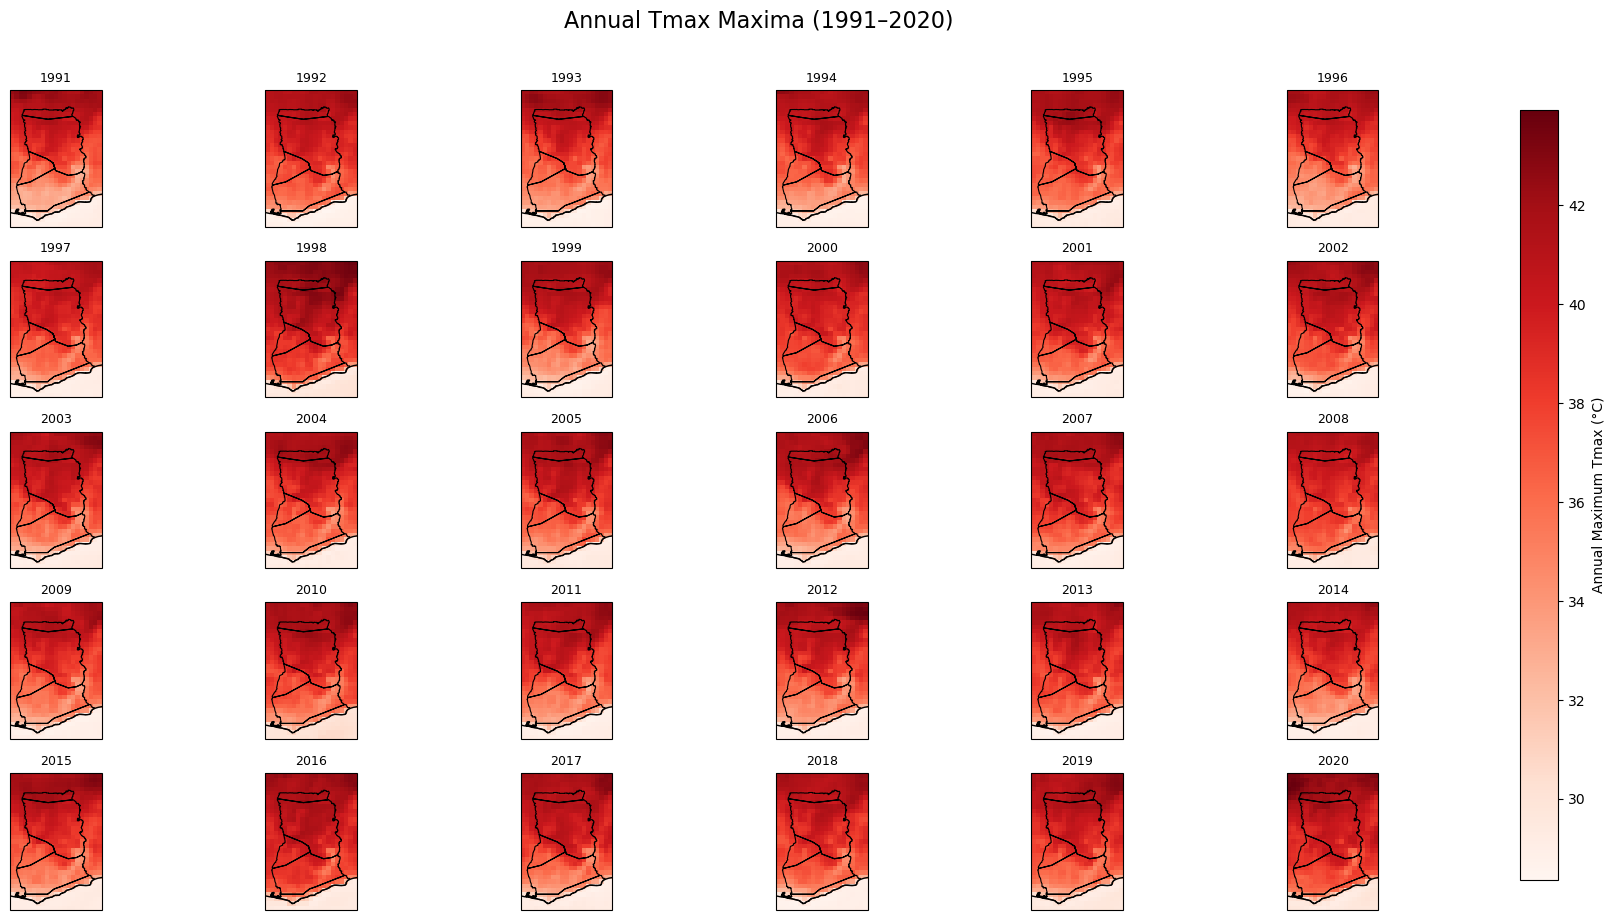

In [6]:
# --- Call plotting function ---
plot_annual_max(Tmax_annual_max, ghana)


In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
import regionmask

# --- Load Tmax data ---
Tmax = xr.open_dataset('Ghana_ERA5_dTx_1991_2023.nc')["mx2t"]

# --- Select period 1991–2023 ---
Tmax = Tmax.sel(valid_time=slice("1991-01-01", "2020-12-31"))

# --- Compute annual maximum ---
Tmax_annual_max = Tmax.groupby("valid_time.year").max(dim="valid_time")

# --- Load Ghana shapefile ---
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# --- Mask to Ghana region only ---
ghana_mask = regionmask.Regions([ghana.geometry.iloc[0]])
Tmax_annual_max_masked = Tmax_annual_max.where(ghana_mask.mask(Tmax_annual_max) == 0)




In [14]:
# --- Plot function ---
def plot_annual_max_masked(da, shapefile_gdf, cmap="Reds", title="Annual Tmax Maxima (1991–2023)"):
    n_years = da.sizes["year"]
    ncols = 6
    nrows = int(np.ceil(n_years / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    im = None

    for i, year in enumerate(da.year.values):
        ax = axes[i]
        data = da.sel(year=year)
        im = data.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap,
            vmin=float(da.min()), vmax=float(da.max())
        )

        # Ghana boundary overlay
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=0.8, transform=ccrs.PlateCarree())
        ax.set_title(str(year), fontsize=9)
        ax.set_extent([ghana.total_bounds[0], ghana.total_bounds[2],
                       ghana.total_bounds[1], ghana.total_bounds[3]],
                      crs=ccrs.PlateCarree())

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label("Annual Maximum Tmax (°C)")

    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.05, right=0.81, top=0.90, bottom=0.08,
                        wspace=0.05, hspace=0.25)
    #plt.tight_layout()
    plt.show()


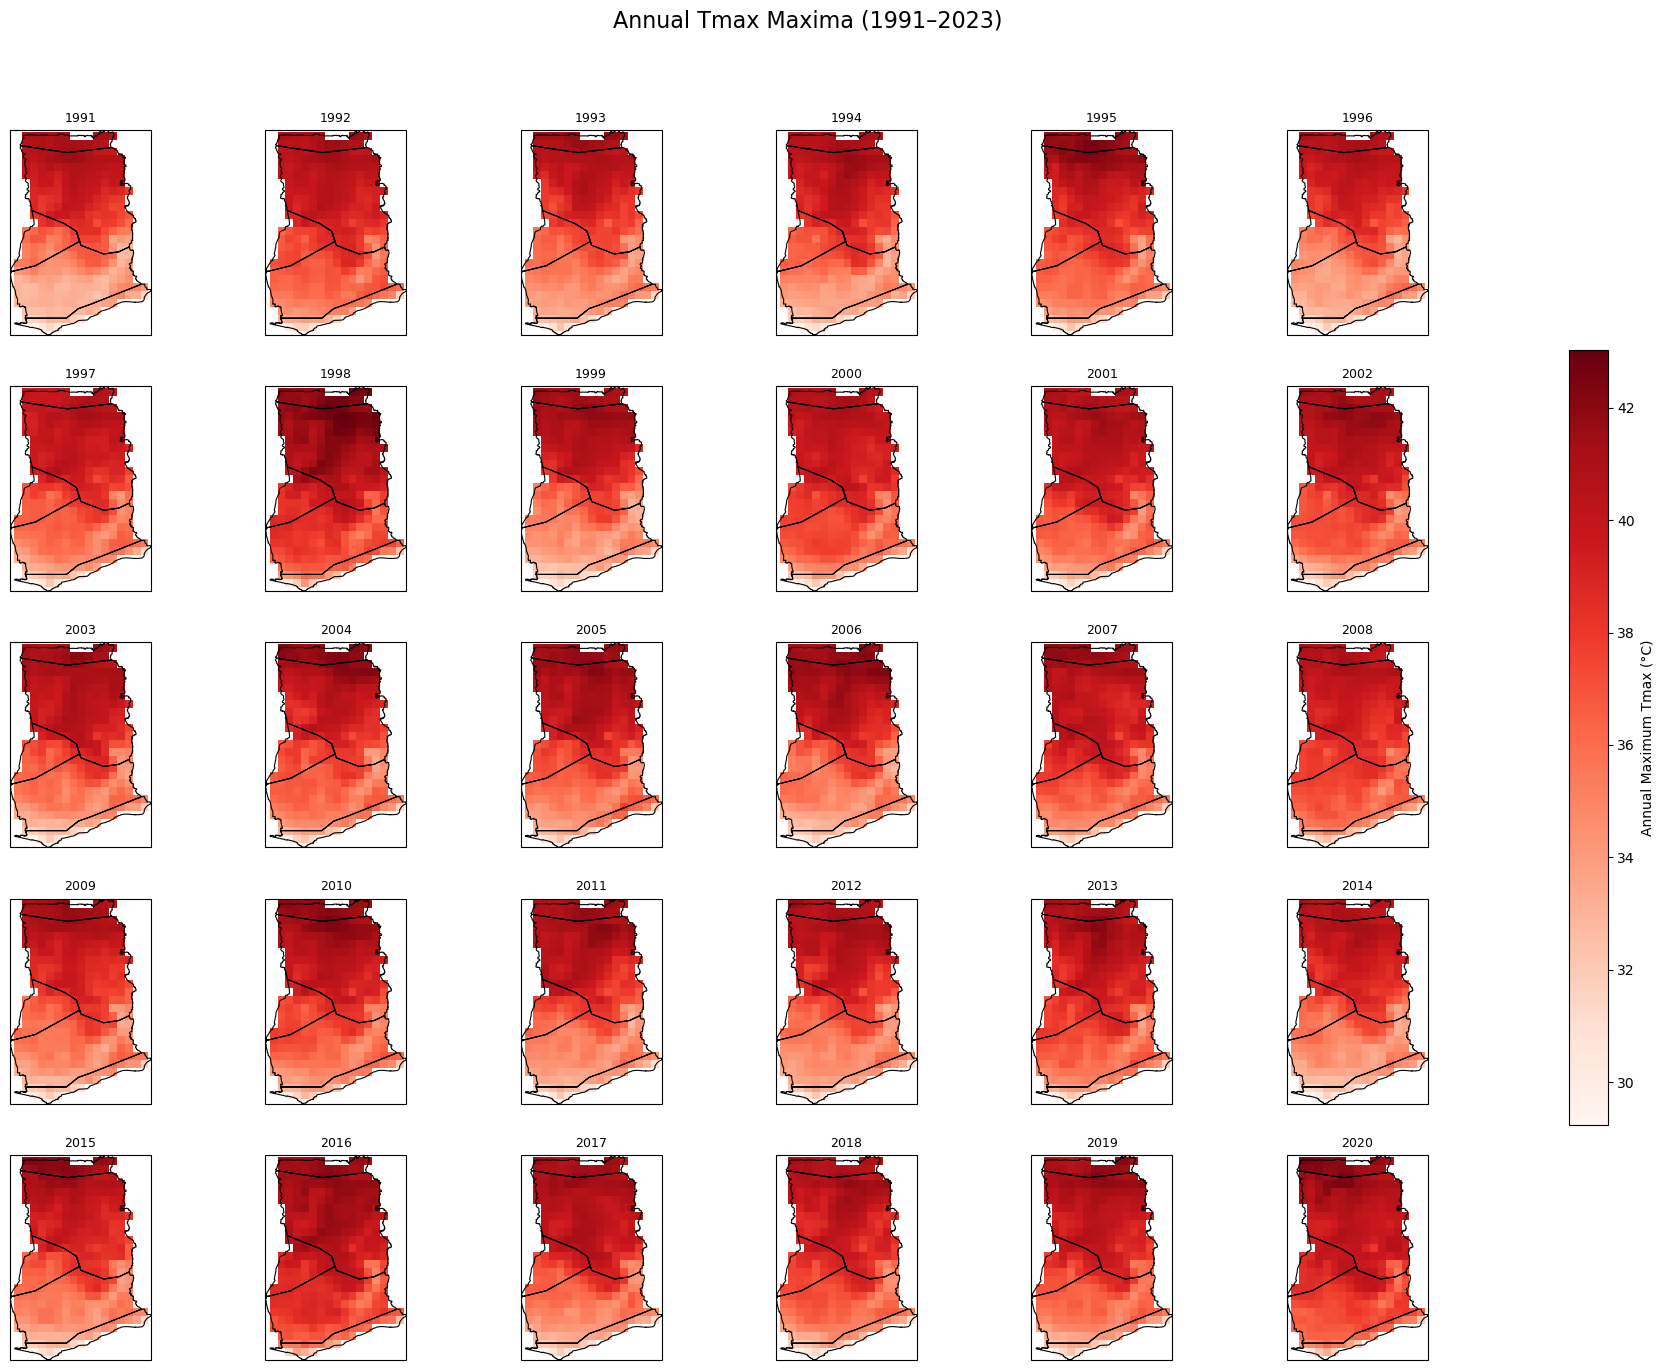

In [15]:
# --- Call plotting function ---
plot_annual_max_masked(Tmax_annual_max_masked, ghana)


In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
import regionmask

# --- Load Tmax data ---
Tmax = xr.open_dataset('Ghana_ERA5_dTx_1991_2023.nc')["mx2t"]

# --- Select period 1991–2020 ---
Tmax = Tmax.sel(valid_time=slice("1991-01-01", "2020-12-31"))

# --- Compute annual 90th percentile ---
Tmax_annual_p90 = Tmax.groupby("valid_time.year").quantile(0.9, dim="valid_time")

# --- Load Ghana shapefile ---
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# --- Mask to Ghana region only ---
ghana_mask = regionmask.Regions([ghana.geometry.iloc[0]])
Tmax_annual_p90_masked = Tmax_annual_p90.where(ghana_mask.mask(Tmax_annual_p90) == 0)



In [17]:
# --- Plot function ---
def plot_annual_p90_masked(da, shapefile_gdf, cmap="coolwarm", title="Annual 90th Percentile Tmax (1991–2020)"):
    n_years = da.sizes["year"]
    ncols = 6
    nrows = int(np.ceil(n_years / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    im = None

    for i, year in enumerate(da.year.values):
        ax = axes[i]
        data = da.sel(year=year)
        im = data.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap,
            vmin=float(da.min()), vmax=float(da.max())
        )

        # Ghana boundary overlay
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=0.8, transform=ccrs.PlateCarree())
        ax.set_title(str(year), fontsize=9)
        ax.set_extent([ghana.total_bounds[0], ghana.total_bounds[2],
                       ghana.total_bounds[1], ghana.total_bounds[3]],
                      crs=ccrs.PlateCarree())

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label("Annual 90th Percentile Tmax (°C)")

    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.05, right=0.81, top=0.90, bottom=0.08,
                        wspace=0.05, hspace=0.25)
    plt.show()



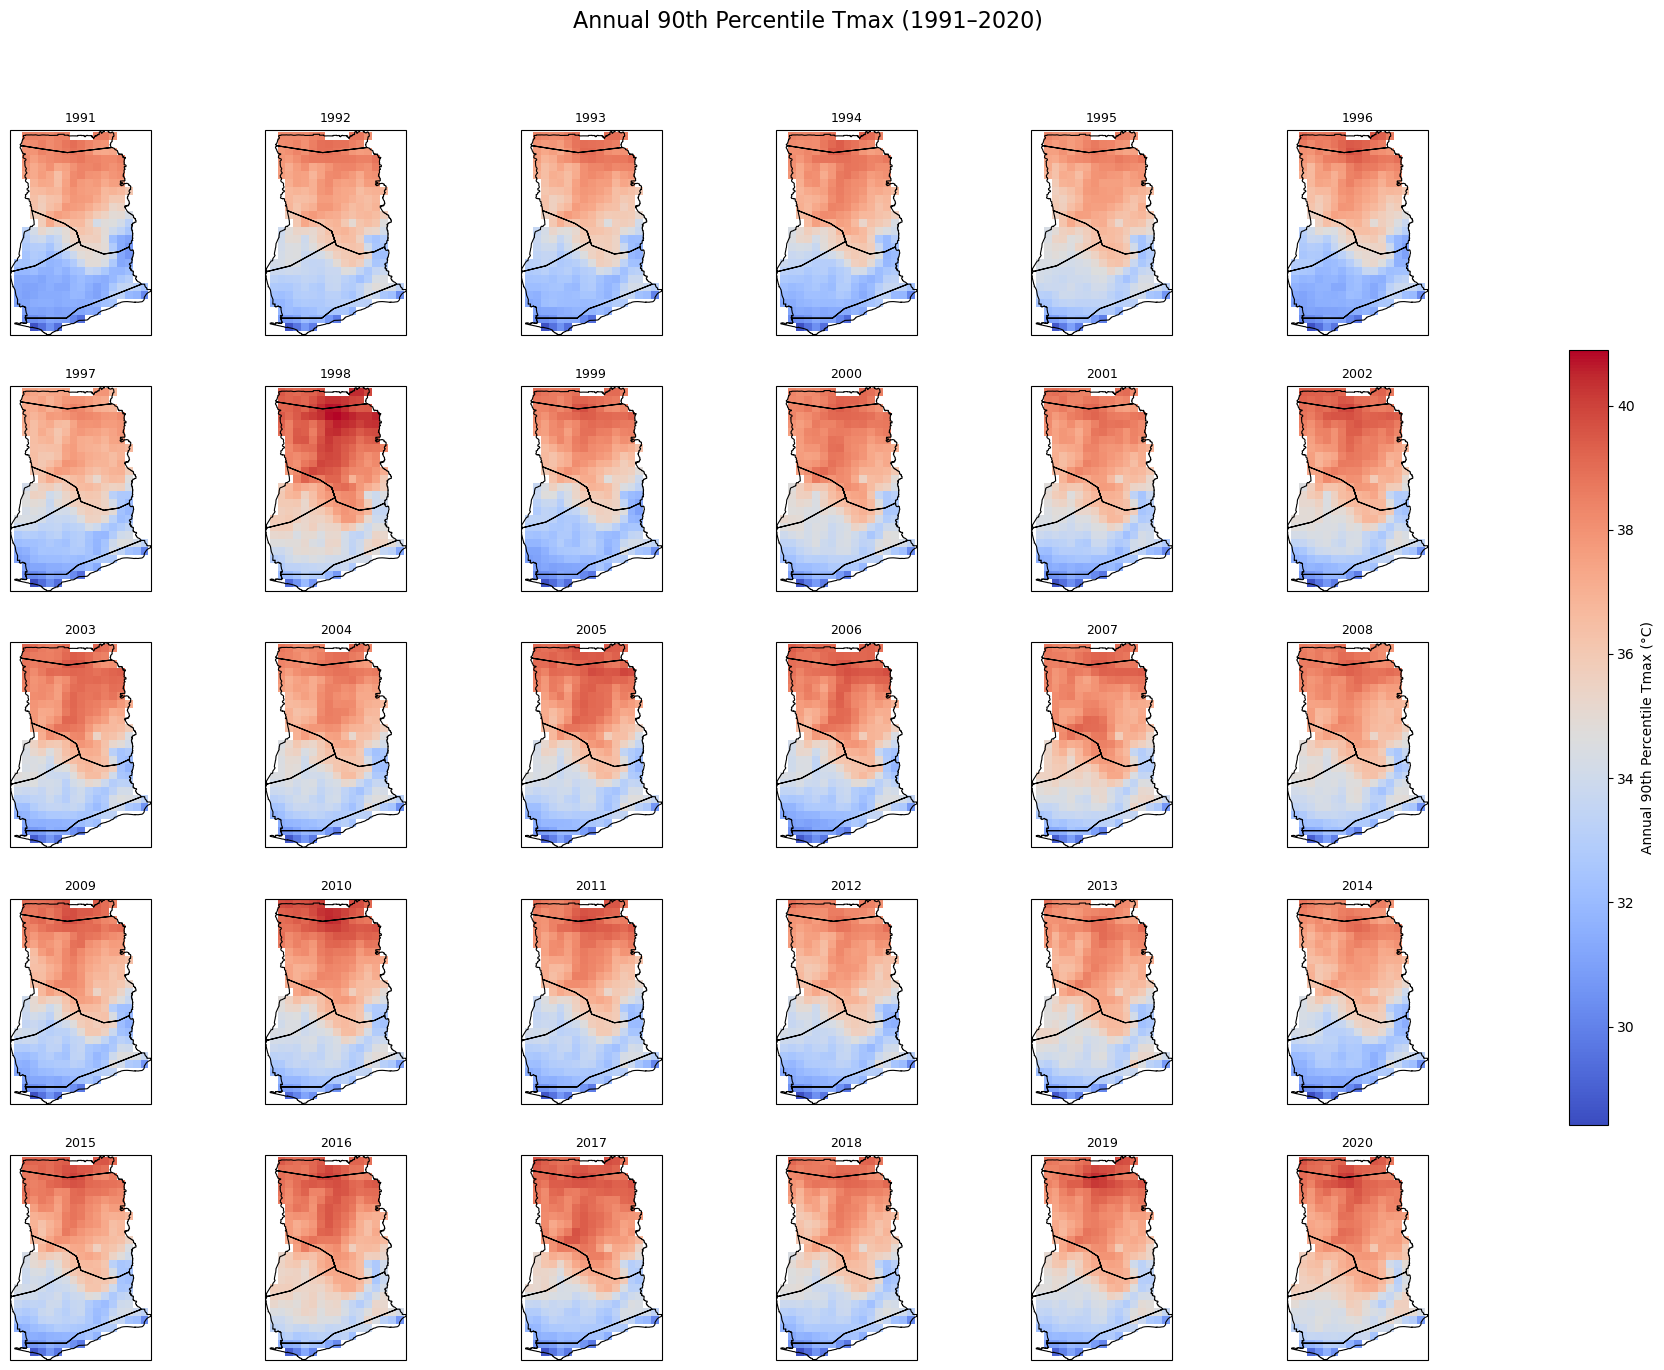

In [18]:
# --- Call plotting function ---
plot_annual_p90_masked(Tmax_annual_p90_masked, ghana)


In [19]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
import regionmask

# --- Load Tmax data ---
Tmax = xr.open_dataset('Ghana_ERA5_dTx_1991_2023.nc')["mx2t"]

# --- Select period 1991–2020 ---
Tmax = Tmax.sel(valid_time=slice("1991-01-01", "2020-12-31"))

# --- Compute 90th percentile threshold (reference climatology) ---
t90 = Tmax.quantile(0.9, dim="valid_time")

# --- Boolean mask of exceedances ---
exceedances = Tmax > t90

# --- Count exceedances per year ---
exceedance_count = exceedances.groupby("valid_time.year").sum(dim="valid_time")

# --- Total days per year ---
days_per_year = Tmax.groupby("valid_time.year").count(dim="valid_time")

# --- Percentage of hot days ---
exceedance_pct = (exceedance_count / days_per_year) * 100
exceedance_pct.name = "HotDaysPct"

# --- Load Ghana shapefile ---
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# --- Mask to Ghana region only ---
ghana_mask = regionmask.Regions([ghana.geometry.iloc[0]])
exceedance_pct_masked = exceedance_pct.where(ghana_mask.mask(exceedance_pct) == 0)




In [33]:
# --- Plotting function ---
def plot_hotdays_pct(da, shapefile_gdf, cmap="YlOrRd", title="Annual % of Days Tmax > 90th Percentile (1991–2020)"):
    n_years = da.sizes["year"]
    ncols = 6
    nrows = int(np.ceil(n_years / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    im = None

    for i, year in enumerate(da.year.values):
        ax = axes[i]
        data = da.sel(year=year)
        im = data.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap,
            vmin=0, vmax=35  # percentages from 0–100
        )

        # Ghana boundary overlay
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=0.8, transform=ccrs.PlateCarree())
        ax.set_title(str(year), fontsize=9)
        ax.set_extent([ghana.total_bounds[0], ghana.total_bounds[2],
                       ghana.total_bounds[1], ghana.total_bounds[3]],
                      crs=ccrs.PlateCarree())

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label("Percentage of Hot Days (%)")

    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.05, right=0.81, top=0.90, bottom=0.08,
                        wspace=0.05, hspace=0.25)
    plt.show()




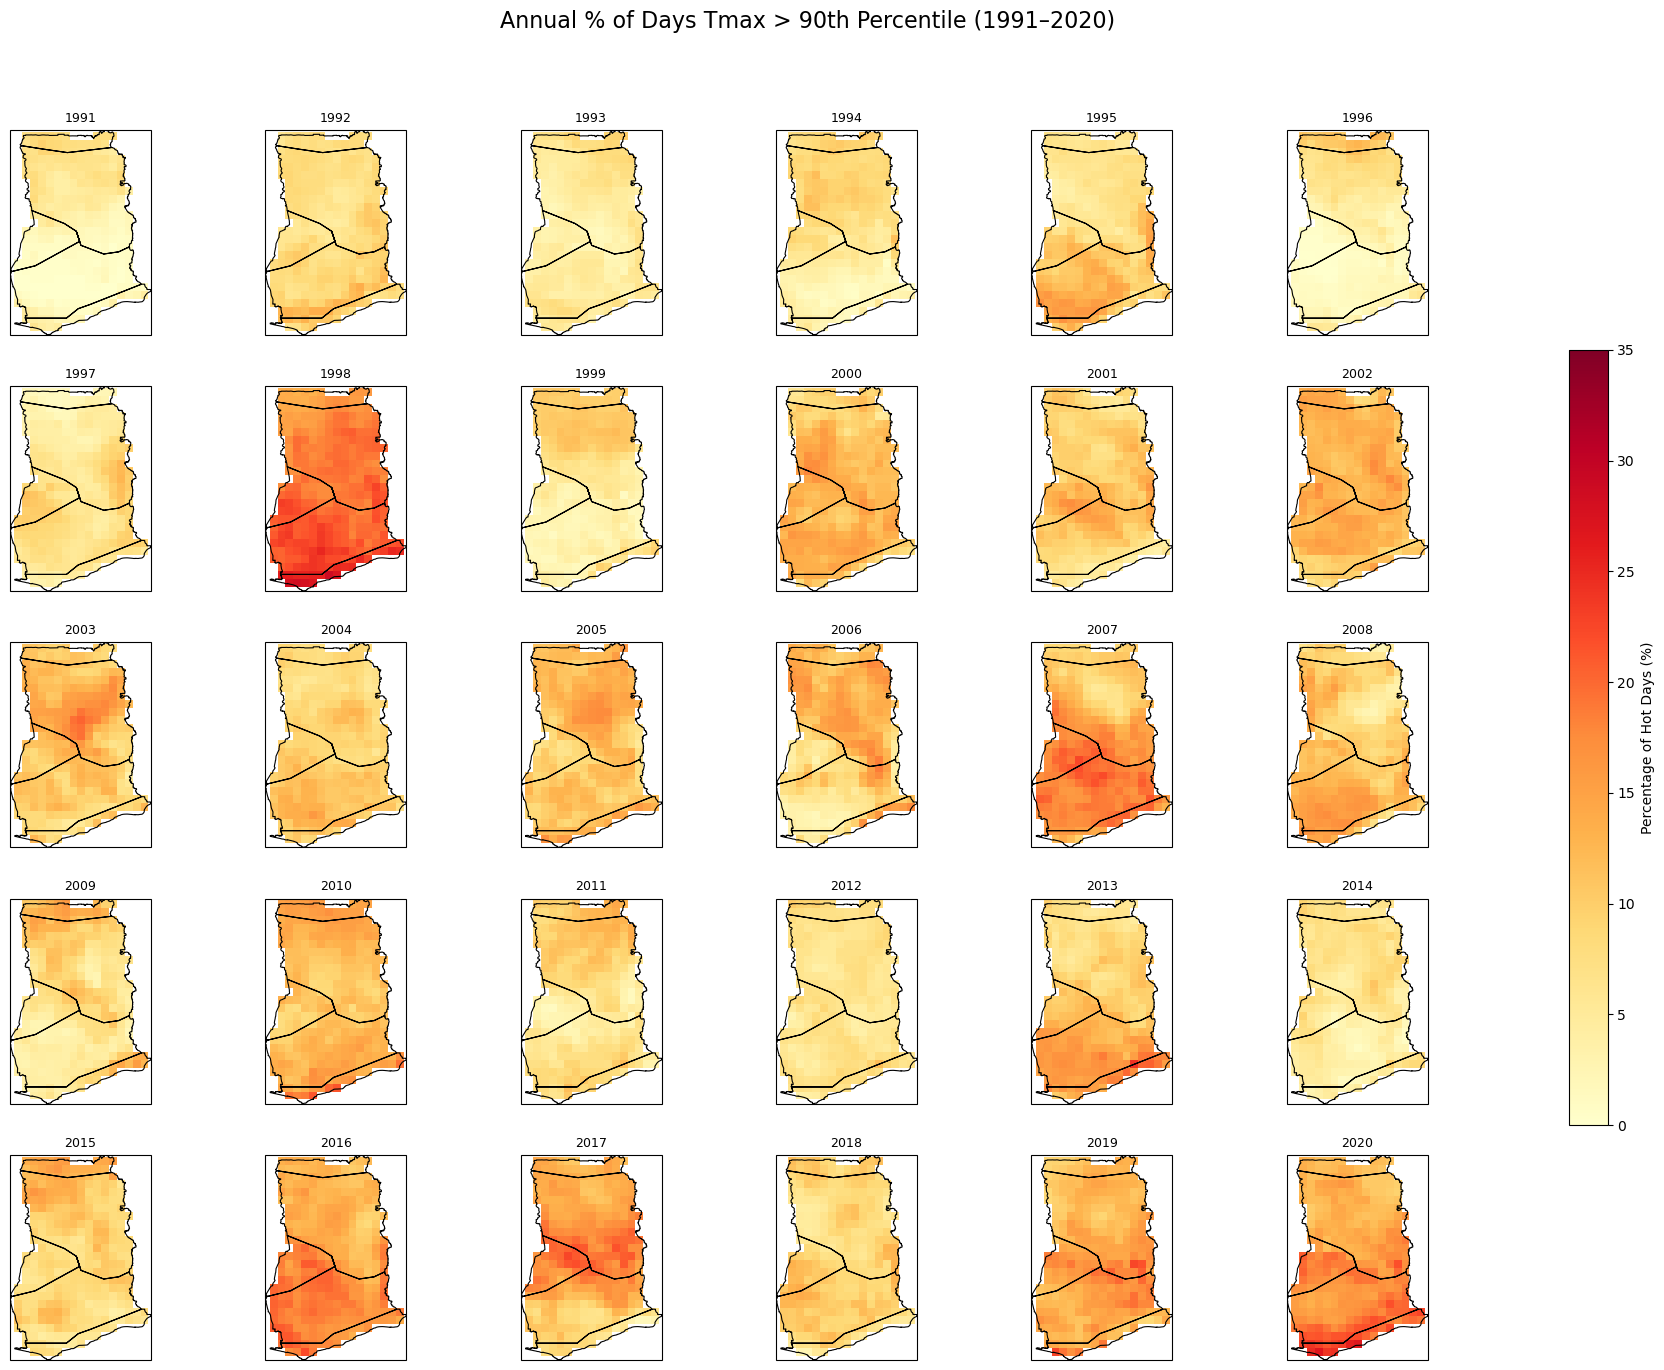

In [34]:
# --- Call plotting function ---
plot_hotdays_pct(exceedance_pct_masked, ghana)


In [35]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
import regionmask
import calendar

# --- Load Tmax data ---
Tmax = xr.open_dataset('Ghana_ERA5_dTx_1991_2023.nc')["mx2t"]

# --- Select period 1991–2020 ---
Tmax = Tmax.sel(valid_time=slice("1991-01-01", "2020-12-31"))

# --- Compute 90th percentile threshold (reference climatology) ---
t90 = Tmax.quantile(0.9, dim="valid_time")

# --- Boolean mask of exceedances ---
exceedances = Tmax > t90

# --- Count exceedances per month ---
exceedance_count_monthly = exceedances.groupby("valid_time.month").sum(dim="valid_time")

# --- Total days per month ---
days_per_month = Tmax.groupby("valid_time.month").count(dim="valid_time")

# --- Percentage of hot days per month ---
exceedance_pct_monthly = (exceedance_count_monthly / days_per_month) * 100
exceedance_pct_monthly.name = "HotDaysPct_Monthly"

# --- Load Ghana shapefile ---
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# --- Mask to Ghana region only ---
ghana_mask = regionmask.Regions([ghana.geometry.iloc[0]])
exceedance_pct_monthly_masked = exceedance_pct_monthly.where(
    ghana_mask.mask(exceedance_pct_monthly) == 0
)



In [38]:
# --- Plotting function ---
def plot_hotdays_pct_monthly(da, shapefile_gdf, cmap="Reds", title="Monthly % of Days Tmax > 90th Percentile (1991–2020)"):
    months = da.month.values
    n_months = len(months)
    ncols = 4
    nrows = int(np.ceil(n_months / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    im = None

    for i, m in enumerate(months):
        ax = axes[i]
        data = da.sel(month=m)
        im = data.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap,
            vmin=0, vmax=100
        )

        # Ghana boundary overlay
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=0.8, transform=ccrs.PlateCarree())
        ax.set_title(calendar.month_name[m], fontsize=10)
        ax.set_extent([ghana.total_bounds[0], ghana.total_bounds[2],
                       ghana.total_bounds[1], ghana.total_bounds[3]],
                      crs=ccrs.PlateCarree())

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label("Percentage of Hot Days (%)")

    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.05, right=0.85, top=0.92, bottom=0.08,
                        wspace=0.1, hspace=0.3)
    plt.show()



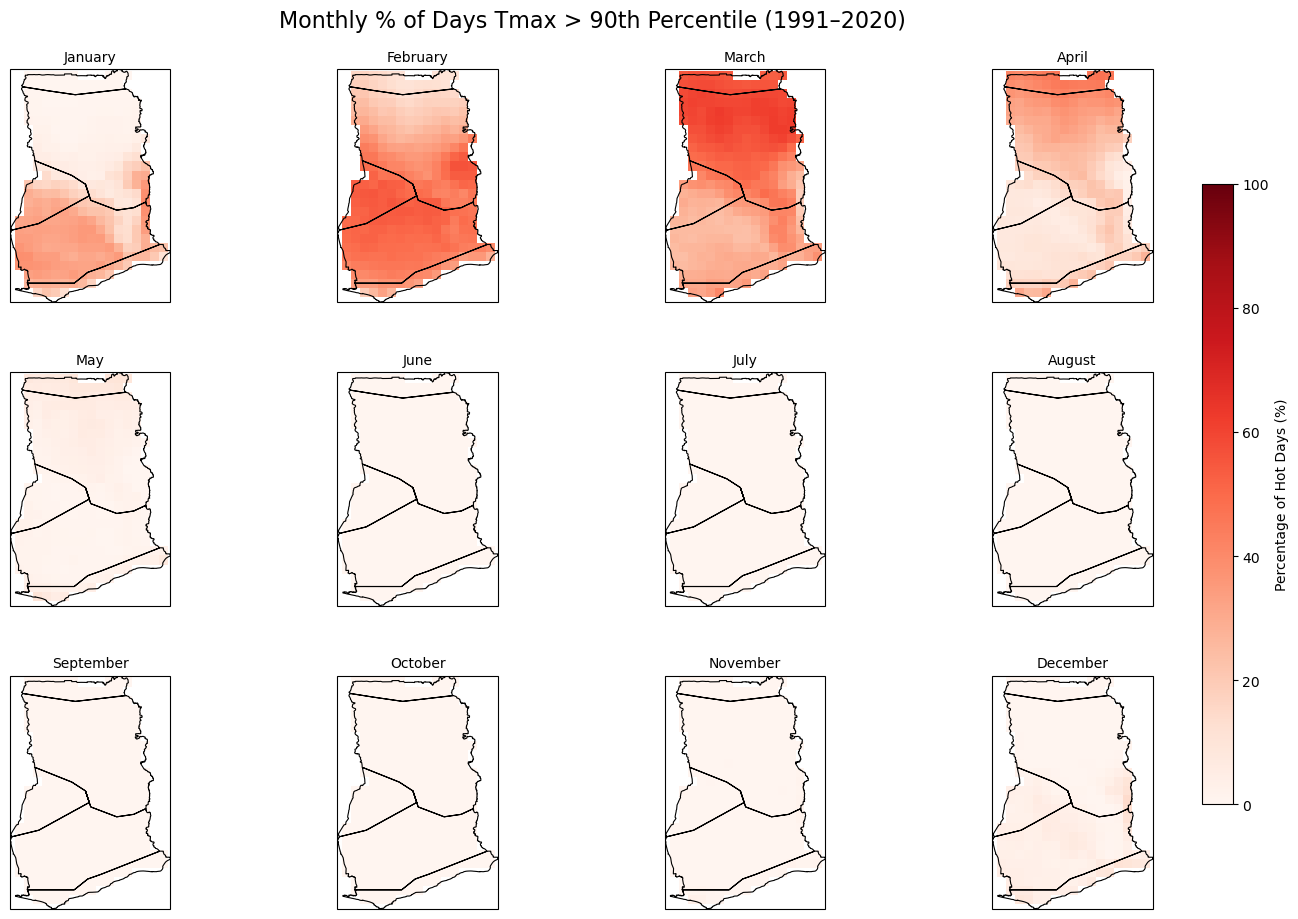

In [39]:
# --- Call plotting function ---
plot_hotdays_pct_monthly(exceedance_pct_monthly_masked, ghana)
